In [8]:
!pip install urllib3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 2.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
kfp 2.5.0 requires urllib3<2.0.0, but you have urllib3 2.2.2 which is incompatible.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
import urllib3
import gc
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
urllib3.disable_warnings()
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [3]:
class Pred:
    def __init__(self):
        return

    def getData(self, fi1):
        htt = urllib3.PoolManager()
        ml = htt.request('GET', fi1)
        ml = ml.data
        da = str(ml)
        return da

    def reformat(self, da):
        i = 0
        FD = []
        lis = []
        pc = []
        dt = []
        no_days_price = da.count('test="relative-most-active-last">')
        no_date = da.count('<time dateTime=')
        ix2 = 2

        for i in range(no_days_price):
            ix1 = da.index('test="relative-most-active-last">', ix2, len(da)) + 33
            ix2 = ix1 + 6
            pc.append(da[ix1:ix2])

        ix2 = 2

        for i in range(no_date):
            ix1 = da.index('<time dateTime=', ix2, len(da)) + 16
            ix2 = ix1 + 12
            dt.append(da[ix1:ix2])

        k = 0

        for i in range(1, no_date):
            FD.append([dt[i], pc[k], pc[k+1], pc[k+2]])
            k += 3

        ##FD.reverse()
        Reformated_data = {
            "Date": [FD[i][0] for i in range(len(FD))],
            "Open": [float(FD[i][1]) for i in range(len(FD))],
            "High": [float(FD[i][2]) for i in range(len(FD))],
            "Low": [float(FD[i][3]) for i in range(len(FD))]
        }

        PriceData = pd.DataFrame(Reformated_data)
        return PriceData

    def estim(self, PriceData):
        model = ARIMA(PriceData['Low'], order=(1, 1, 1))
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=30)

        train_size = int(len(PriceData) * 0.8)
        train, test = PriceData[0:train_size], PriceData[train_size:len(PriceData)]

        model_train = ARIMA(train['Low'], order=(1, 1, 1))
        model_train_fit = model_train.fit()
        test_forecast = model_train_fit.get_forecast(steps=len(test))
        test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

        mse = mean_squared_error(test['Low'], test_forecast_series)
        rmse = mse ** 0.5

        model2 = ARIMA(PriceData['High'], order=(1, 1, 1))
        model_fit2 = model2.fit()
        forecast2 = model_fit2.get_forecast(steps=30)

        train_size2 = int(len(PriceData) * 0.8)
        train2, test2 = PriceData[0:train_size2], PriceData[train_size2:len(PriceData)]

        model_train2 = ARIMA(train2['High'], order=(1, 1, 1))
        model_train_fit2 = model_train2.fit()
        test_forecast2 = model_train_fit2.get_forecast(steps=len(test2))
        test_forecast_series2 = pd.Series(test_forecast2.predicted_mean, index=test2.index)

        mse2 = mean_squared_error(test2['High'], test_forecast_series2)
        rmse2 = mse2 ** 0.5

        plt.figure(figsize=(14, 7))
        plt.plot(train['Low'], label='Training Low', color='red')
        plt.plot(test['Low'], label='Actual Low', color='red')
        plt.plot(test_forecast_series, label='Forecasted Low', color='yellow')
        plt.plot(train2['High'], label='Training High', color='blue')
        plt.plot(test2['High'], label='Actual High', color='blue')
        plt.plot(test_forecast_series2, label='Forecasted High', color='green')
        plt.fill_between(test.index, test_forecast.conf_int().iloc[:, 0],
                         test_forecast.conf_int().iloc[:, 1], color='k', alpha=.15)
        plt.fill_between(test2.index, test_forecast2.conf_int().iloc[:, 0],
                         test_forecast2.conf_int().iloc[:, 1], color='k', alpha=.15)
        plt.title('ARIMA Model Evaluation')
        plt.xlabel('Day')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

        return [rmse, rmse2]

In [4]:
w=Pred()

In [6]:
e=w.getData('https://www.investing.com/currencies/gbp-usd-historical-data')
ee=w.reformat(e)

In [7]:
ee

,Date,Open,High,Low
0,"Jul 29, 2024",1.2859,1.2865,1.2820
1,"Jul 28, 2024",1.2866,1.2889,1.2807
2,"Jul 25, 2024",1.2852,1.2880,1.2849
3,"Jul 24, 2024",1.2907,1.2917,1.2849
4,"Jul 23, 2024",1.2907,1.2939,1.2876
5,"Jul 22, 2024",1.2934,1.2937,1.2887
6,"Jul 21, 2024",1.2912,1.2944,1.2904
7,"Jul 18, 2024",1.2944,1.2955,1.2900
8,"Jul 17, 2024",1.3010,1.3015,1.2939
9,"Jul 16, 2024",1.2973,1.3046,1.2965


# Fitting ARIMA for GBPUSD data for the last 30 days

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


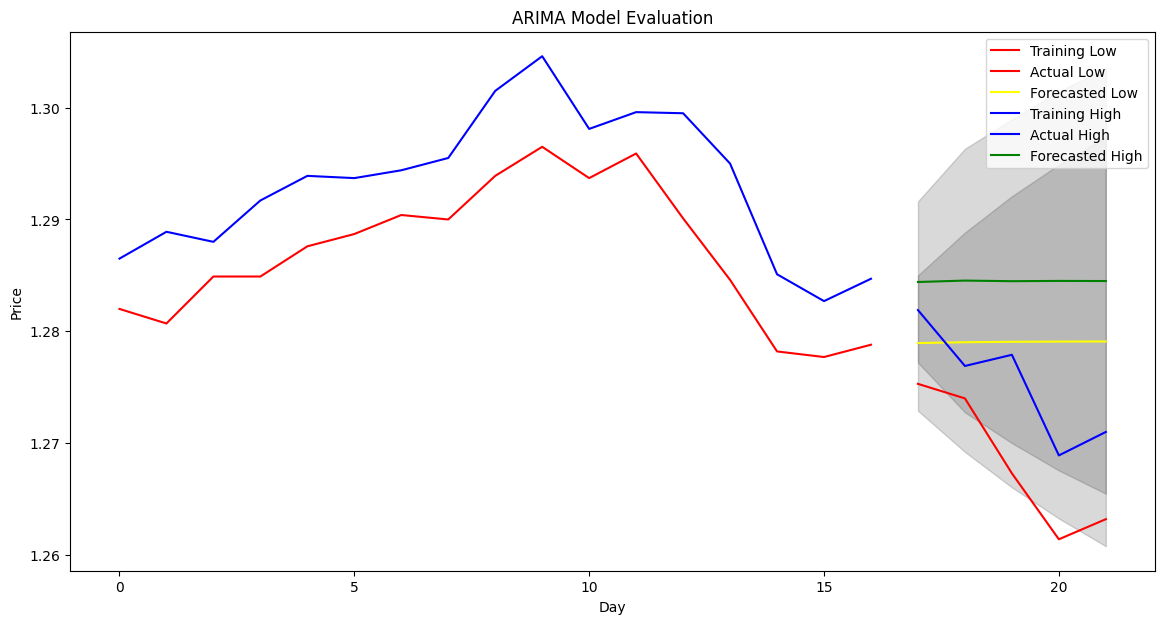

In [8]:
et2=w.estim(ee)

In [9]:
e=w.getData('https://www.investing.com/currencies/eur-usd-historical-data')
ee=w.reformat(e)

In [10]:
ee

,Date,Open,High,Low
0,"Jul 29, 2024",1.0819,1.0836,1.0798
1,"Jul 28, 2024",1.0852,1.0870,1.0802
2,"Jul 25, 2024",1.0847,1.0869,1.0841
3,"Jul 24, 2024",1.0840,1.0870,1.0827
4,"Jul 23, 2024",1.0854,1.0868,1.0826
5,"Jul 22, 2024",1.0892,1.0898,1.0843
6,"Jul 21, 2024",1.0881,1.0904,1.0872
7,"Jul 18, 2024",1.0901,1.0903,1.0876
8,"Jul 17, 2024",1.0938,1.0941,1.0893
9,"Jul 16, 2024",1.0899,1.0948,1.0895


# Fitting ARIMA for EURUSD data for the last 30 days

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


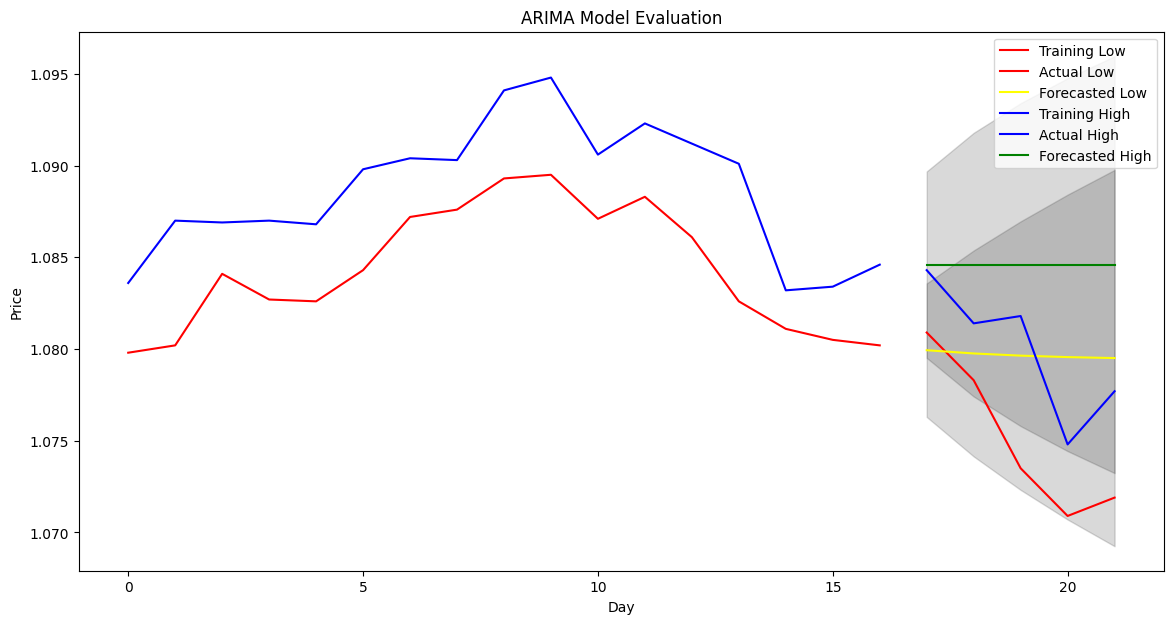

In [11]:
et2=w.estim(ee)

In [12]:
e=w.getData('https://www.investing.com/currencies/usd-jpy-historical-data')
ee=w.reformat(e)

In [13]:
ee

,Date,Open,High,Low
0,"Jul 29, 2024",153.82,155.22,152.99
1,"Jul 28, 2024",154.16,154.36,153.03
2,"Jul 25, 2024",153.95,154.75,153.13
3,"Jul 24, 2024",153.90,154.33,151.94
4,"Jul 23, 2024",155.55,155.99,153.10
5,"Jul 22, 2024",157.03,157.11,155.56
6,"Jul 21, 2024",157.45,157.63,156.28
7,"Jul 18, 2024",157.38,157.88,156.96
8,"Jul 17, 2024",156.15,157.41,155.37
9,"Jul 16, 2024",158.35,158.63,156.06


# Fitting ARIMA for USDJPY data for the last 30 days

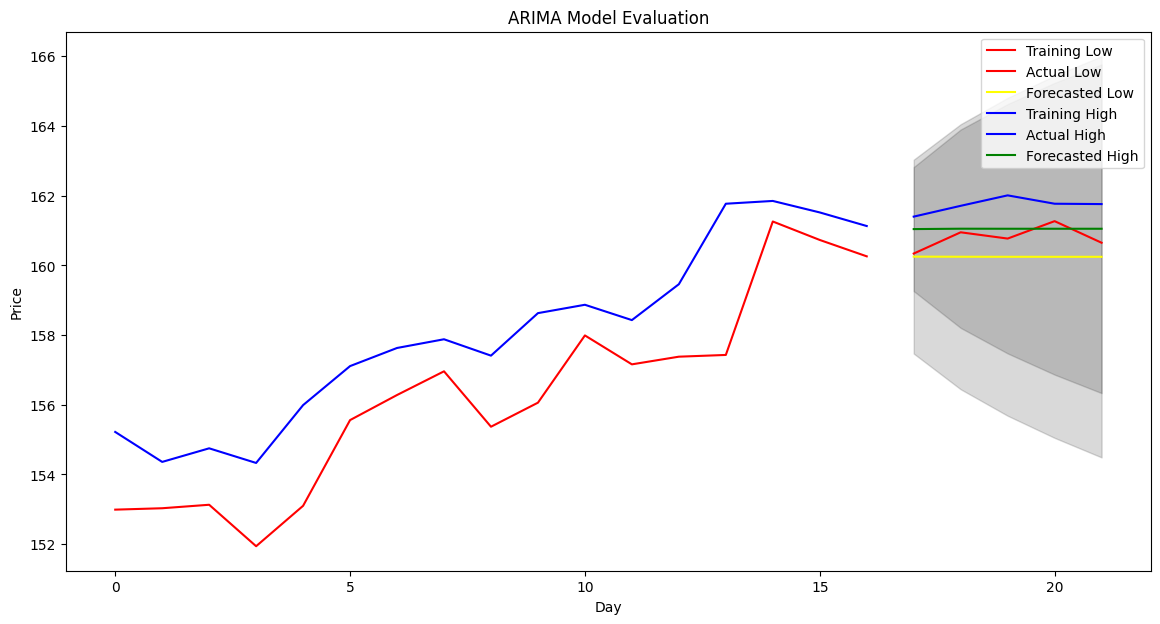

In [14]:
et2=w.estim(ee)


In [15]:
e=w.getData('https://www.investing.com/currencies/eur-jpy-historical-data')
ee=w.reformat(e)

In [16]:
ee

,Date,Open,High,Low
0,"Jul 29, 2024",166.43,167.95,165.45
1,"Jul 28, 2024",167.30,167.52,166.24
2,"Jul 25, 2024",166.97,168.03,166.35
3,"Jul 24, 2024",166.84,167.63,164.82
4,"Jul 23, 2024",168.87,169.23,166.13
5,"Jul 22, 2024",171.02,171.12,168.82
6,"Jul 21, 2024",171.38,171.68,170.07
7,"Jul 18, 2024",171.48,171.90,170.90
8,"Jul 17, 2024",170.82,171.60,169.98
9,"Jul 16, 2024",172.59,172.86,170.69


# Fitting ARIMA for EURJPY data for the last 30 days

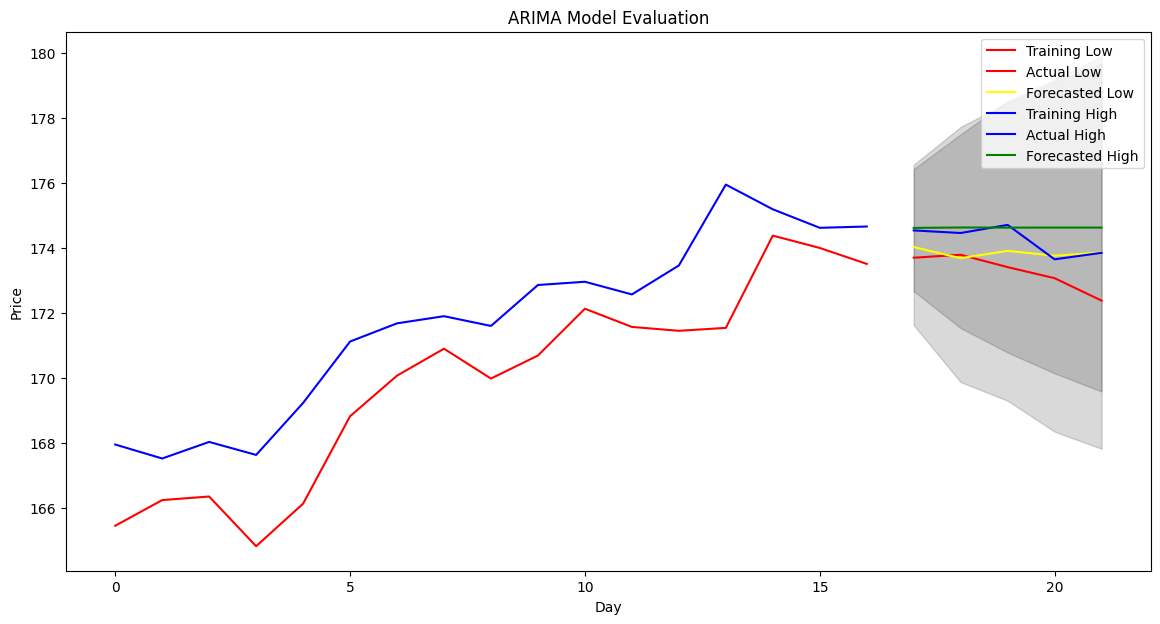

In [17]:
et2=w.estim(ee)

In [18]:
e=w.getData('https://www.investing.com/currencies/gbp-jpy-historical-data')
ee=w.reformat(e)


In [19]:
ee

,Date,Open,High,Low
0,"Jul 29, 2024",197.82,199.48,196.36
1,"Jul 28, 2024",198.36,198.62,196.79
2,"Jul 25, 2024",197.85,199.18,196.93
3,"Jul 24, 2024",198.63,198.85,195.85
4,"Jul 23, 2024",200.83,201.22,197.76
5,"Jul 22, 2024",203.09,203.19,200.72
6,"Jul 21, 2024",203.37,203.65,201.87
7,"Jul 18, 2024",203.72,204.27,202.93
8,"Jul 17, 2024",203.18,203.90,202.09
9,"Jul 16, 2024",205.34,205.72,202.99


# Fitting ARIMA for GBPJPY data for the last 30 days

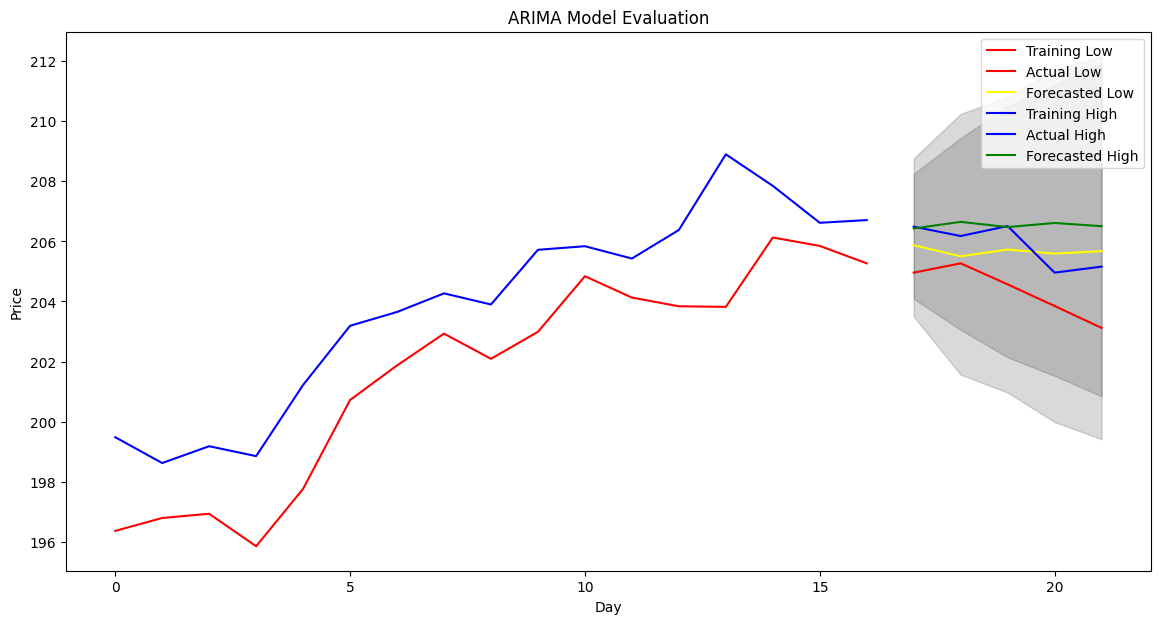

In [20]:
et2=w.estim(ee)